### Importing Modules (p472)

In [1]:
from collections import defaultdict
    
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy # used internally by statsmodels 
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Introduction to Statistical Modeling (p473)

### Defining Statistical Models with Patsy (p474)

In [3]:
# observed values : y
y = np.array([1, 2, 3, 4, 5])

# independent variables : x1, x2
x1 = np.array([6, 7, 8, 9, 10])
x2 = np.array([11, 12, 13, 14, 15])

# design matrix : [1, x1, x2, x1x2]
X = np.vstack([np.ones(5), x1, x2, x1*x2]).T
X

array([[  1.,   6.,  11.,  66.],
       [  1.,   7.,  12.,  84.],
       [  1.,   8.,  13., 104.],
       [  1.,   9.,  14., 126.],
       [  1.,  10.,  15., 150.]])

In [4]:
# solve for the unknown coefficient vector B
# using least-square-fit given the design matrix X
# and observation vector y
beta, res, rank, sval = np.linalg.lstsq(X, y, rcond=None)
beta

array([-5.55555556e-01,  1.88888889e+00, -8.88888889e-01, -1.11022302e-15])

In [5]:
# Patsy offers a convenient formula for defining a model
# and automatically constructing the relevant design matrices
data = {"y": y, "x1": x1, "x2": x2}
y, X = patsy.dmatrices("y ~ 1 + x1 + x2 + x1*x2", data)

In [6]:
# the design matrices for the given data
y

DesignMatrix with shape (5, 1)
  y
  1
  2
  3
  4
  5
  Terms:
    'y' (column 0)

In [7]:
# specified model formula
X

DesignMatrix with shape (5, 4)
  Intercept  x1  x2  x1:x2
          1   6  11     66
          1   7  12     84
          1   8  13    104
          1   9  14    126
          1  10  15    150
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)
    'x1:x2' (column 3)

In [8]:
# Patsy-supplied subclass of the standard NumPy array contains
# additional metadata and an altered printing representation
type(X)

patsy.design_info.DesignMatrix

In [9]:
# (optional) cast DesignMatrix instance into an ndarray object
np.array(X)

array([[  1.,   6.,  11.,  66.],
       [  1.,   7.,  12.,  84.],
       [  1.,   8.,  13., 104.],
       [  1.,   9.,  14., 126.],
       [  1.,  10.,  15., 150.]])

In [10]:
# set return_type to dataframe so that patsy.dmatrices funciton
# returns design matrices in the form of Pandas Dataframe
df_data = pd.DataFrame(data)
y, X = patsy.dmatrices(
    "y ~ 1 + x1 + x2 + x1:x2",
    df_data,
    return_type="dataframe"
)
X

,Intercept,x1,x2,x1:x2
0,1.0,6.0,11.0,66.0
1,1.0,7.0,12.0,84.0
2,1.0,8.0,13.0,104.0
3,1.0,9.0,14.0,126.0
4,1.0,10.0,15.0,150.0


In [11]:
# invoke the fit method to fit the model to the data 
# encoded in the design matrices
model = sm.OLS(y, X)
result = model.fit()
result.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -7.771561e-16
dtype: float64

In [12]:
# pass the Patsy formula for the model when creating a model instance
# using the statsmodels formula API
model = smf.ols("y ~ 1 + x1 + x2 + x1:x2", df_data)
result = model.fit()
result.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -7.771561e-16
dtype: float64

In [13]:
data = defaultdict(lambda: np.array([]))
patsy.dmatrices("y ~ a", data=data)[1].design_info.term_names

['Intercept', 'a']

In [14]:
# Patsy includes the intercept constant by default
# which can be written explicitly using y ~ 1 + a
patsy.dmatrices("y ~ 1 + a + b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b']

In [15]:
# use the notation -1 to remove the intercept in the model
patsy.dmatrices("y ~ -1 + a + b", data=data)[1].design_info.term_names

['a', 'b']

In [16]:
# a * b are expanded to include all lower-order interaction terms
patsy.dmatrices("y ~ a * b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b']

In [17]:
# higher-order expansions
patsy.dmatrices("y ~ a * b * c", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b', 'c', 'a:c', 'b:c', 'a:b:c']

In [18]:
# remove certain term from a formula
patsy.dmatrices("y ~ a * b * c - a:b:c", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b', 'c', 'a:c', 'b:c']

In [19]:
# + and - are used for set-like operations
data = {k: np.array([]) for k in ["y", "a", "b", "c"]}
patsy.dmatrices("y ~ a + b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b']

In [20]:
# need to wrap the expression in a function call (e.g. I(...))
# to represent the arithmetic operations
patsy.dmatrices("y ~ I(a + b)", data=data)[1].design_info.term_names

['Intercept', 'I(a + b)']

In [21]:
# express a power of a variable
patsy.dmatrices("y ~ I(a**2)", data=data)[1].design_info.term_names

['Intercept', 'I(a ** 2)']

In [22]:
# apply transformations of the input data using 
# arbitrary Python function calls in the formula
patsy.dmatrices("y ~ np.log(a) + b", data=data)[1].design_info.term_names

['Intercept', 'np.log(a)', 'b']

In [23]:
# transform variables
z = lambda x1, x2: x1+x2
patsy.dmatrices("y ~ z(a, b)", data=data)[1].design_info.term_names

['Intercept', 'z(a, b)']

In [24]:
# for a numerical variable, the corresponding column in the design matrix
# corresponds to the data vector
data = {"y": [1, 2, 3], "a": [1, 2, 3]}
patsy.dmatrices("y ~ - 1 + a", data=data, return_type="dataframe")[1]

,a
0,1.0
1,2.0
2,3.0


In [25]:
# request that a variable should be treated as a categorical variable
# using C(x) notation
patsy.dmatrices("y ~ - 1 + C(a)", data=data, return_type="dataframe")[1]

,C(a)[1],C(a)[2],C(a)[3]
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [26]:
# variables with nonnumerical values are interpreted/treated 
# as categorical values
data = {"y": [1, 2, 3], "a": ["type A", "type B", "type C"]}
patsy.dmatrices("y ~ - 1 + a", data=data, return_type="dataframe")[1]

,a[type A],a[type B],a[type C]
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [27]:
# encode the categorical variables with orthogonoal polynomials
# using C(a, Poly)
patsy.dmatrices("y ~ - 1 + C(a, Poly)", data=data, return_type="dataframe")[1]

,"C(a, Poly).Constant","C(a, Poly).Linear","C(a, Poly).Quadratic"
0,1.0,-7.071068e-01,0.408248
1,1.0,-5.551115e-17,-0.816497
2,1.0,7.071068e-01,0.408248


### Linear Regression (p485)

In [28]:
# prepare random data
N = 100
x1 = np.random.randn(N)
x2 = np.random.randn(N)
data = pd.DataFrame({"x1": x1, "x2": x2})

# store the true value of y in the y_true
def y_true(x1, x2):
    return 1 + 2 * x1 + 3 * x2 + 4 * x1 * x2
data["y_true"] = y_true(x1, x2)

In [29]:
# add a normal distributed noise to the true value
e = 0.5 * np.random.randn(N)
data["y"] = data["y_true"] + e

In [30]:
# fit the model to the data using OLS
model = smf.ols("y ~ x1 + x2", data)
result = model.fit()

In [31]:
# display several types of test statistics, ...
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     62.93
Date:                Sat, 04 Jan 2020   Prob (F-statistic):           3.02e-18
Time:                        08:07:07   Log-Likelihood:                -254.43
No. Observations:                 100   AIC:                             514.9
Df Residuals:                      97   BIC:                             522.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4764      0.314      1.516      0.1

In [32]:
# access R-squared statistic
result.rsquared

0.5647401620064987

In [33]:
# access residuals to investigate whether the assumption of
# normal distributed errors is justified
result.resid.head()

0   -0.269274
1   -6.113573
2    0.684272
3   -0.704531
4    8.777530
dtype: float64

In [34]:
# check for normality
z, p = stats.normaltest(result.fittedvalues.values)
p

0.7704388462396615

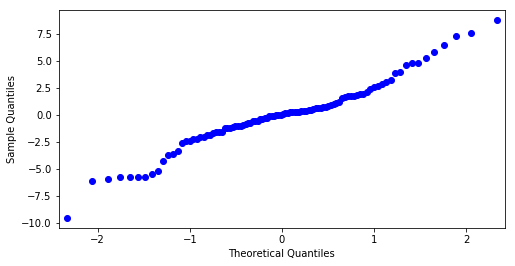

In [35]:
# compare the sample quantiles with the theoretical quantiles
# and the QQ-plot should be close to a straight line if the sampled
# values are normally distributed
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax);

In [36]:
# include the interaction term (x1*x2)
model = smf.ols("y ~ x1 + x2 + x1*x2", data)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2283.
Date:                Sat, 04 Jan 2020   Prob (F-statistic):           4.36e-89
Time:                        08:07:07   Log-Likelihood:                -81.947
No. Observations:                 100   AIC:                             171.9
Df Residuals:                      96   BIC:                             182.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9447      0.057     16.588      0.0

In [37]:
# R-squared statistic is higher
result.rsquared

0.9861788779453743

In [38]:
z, p = stats.normaltest(result.fittedvalues.values)
p

1.3452634026655493e-07

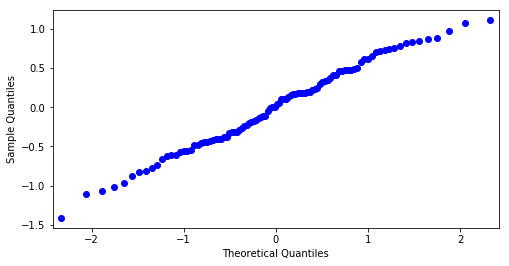

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax);

In [40]:
# extract the model coefficients from the result object
result.params

Intercept    0.944746
x1           2.046557
x2           3.037000
x1:x2        3.946621
dtype: float64

In [41]:
# construct a DataFrame with the x1 and x2 values
x = np.linspace(-1, 1, 50)
X1, X2 = np.meshgrid(x, x)
new_data = pd.DataFrame({"x1": X1.ravel(), "x2": X2.ravel()})

In [42]:
# use the predict method of the result object obtained from
# the fitting of the model to compute the predicted y values
y_pred = result.predict(new_data)

In [43]:
# resize the y_pred vector to a square matrix
y_pred = y_pred.values.reshape(50, 50)

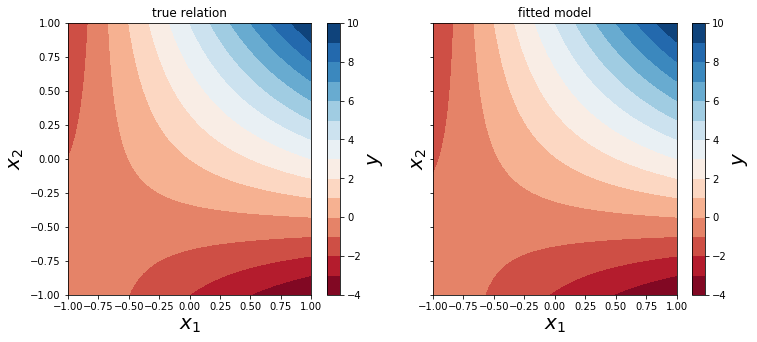

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
def plot_y_contour(ax, Y, title):
    c = ax.contourf(X1, X2, Y, 15, cmap=plt.cm.RdBu)
    ax.set_xlabel(r"$x_1$", fontsize=20)
    ax.set_ylabel(r"$x_2$", fontsize=20)
    ax.set_title(title)
    cb = fig.colorbar(c, ax=ax)
    cb.set_label(r"$y$", fontsize=20)

plot_y_contour(axes[0], y_true(X1, X2), "true relation")
plot_y_contour(axes[1], y_pred, "fitted model")